# Tutorial 5: A Better Standard - Bias Correction

So far, we have learned how to get an MI estimate. But is that estimate *correct*? Is it *reliable*? For scientific research, a single number is not enough. We need to be sure that our result is not an artifact of our limited data.

This tutorial tackles the most important concept for producing publishable results: **bias correction**. We will demonstrate two critical statistical pitfalls and show how `NeuralMI`'s flagship `'rigorous'` mode solves them.

## 1. The Problems with Naive Estimates

Using an MI estimator naively with `mode='estimate'` is fast, but it doesn't account for two critical issues:

1.  **Estimator Variance:** Due to the random nature of neural network training (e.g., weight initialization, data shuffling), running the same estimation twice will give slightly different answers.
2.  **Finite-Sampling Bias:** This is the bigger problem. With a finite dataset, estimators tend to find spurious correlations in the noise, which leads them to **systematically overestimate** the true MI. This bias gets worse as the amount of data gets smaller.

Let's demonstrate these problems in code.

In [25]:
import numpy as np
import neural_mi as nmi
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

# --- Generate Data ---
# We use a moderate number of samples to ensure the bias is visible.
n_samples = 2500
x_raw, y_raw = nmi.datasets.generate_nonlinear_from_latent(
    n_samples=n_samples, latent_dim=10, observed_dim=100, mi=3.0
)
x_raw_transposed = x_raw.T
y_raw_transposed = y_raw.T

### Problem 1: Estimator Variance

Let's run the exact same estimation twice, changing only the `random_seed`.

In [34]:
base_params = {
    'n_epochs': 100, 
    'learning_rate': 5e-4, 
    'batch_size': 128,
    'patience': 20,
    'embedding_dim': 20, 
    'hidden_dim': 256, 
    'n_layers': 3
}

print("--- Demonstrating Estimator Variance ---")
results_1 = nmi.run(x_data=x_raw_transposed, y_data=y_raw_transposed, mode='estimate', processor_type_x='continuous', processor_params_x={'window_size': 1}, base_params=base_params, random_seed=42, verbose=False)
results_2 = nmi.run(x_data=x_raw_transposed, y_data=y_raw_transposed, mode='estimate', processor_type_x='continuous', processor_params_x={'window_size': 1}, base_params=base_params, random_seed=123, verbose=False)

print(f"Run 1 (seed=42):  {results_1.mi_estimate:.3f} bits")
print(f"Run 2 (seed=123): {results_2.mi_estimate:.3f} bits")

--- Demonstrating Estimator Variance ---
2025-10-07 22:59:29 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/1 [00:00<?, ?it/s]

2025-10-07 22:59:33 - neural_mi - INFO - Parameter sweep finished.
2025-10-07 22:59:33 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/1 [00:00<?, ?it/s]

2025-10-07 22:59:37 - neural_mi - INFO - Parameter sweep finished.
Run 1 (seed=42):  2.737 bits
Run 2 (seed=123): 2.591 bits


Notice that the estimates are slightly different. While not a huge difference, this instability is not ideal for science.

### Problem 2: Finite-Sampling Bias

Now for the more serious issue. What happens if we had collected only **half** as much data? A true property of the system shouldn't change just because we have less data, but our estimate does.

In [35]:
print("\n--- Demonstrating Finite-Sampling Bias ---")
# Run the estimation on only the first half of the data
half_samples = n_samples // 2
results_half_data = nmi.run(x_data=x_raw_transposed[:, :half_samples], y_data=y_raw_transposed[:, :half_samples], mode='estimate', processor_type_x='continuous', processor_params_x={'window_size': 1}, base_params=base_params, random_seed=42, verbose=False)

print(f"Estimate on ALL data ({n_samples} samples):   {results_1.mi_estimate:.3f} bits")
print(f"Estimate on HALF data ({half_samples} samples):  {results_half_data.mi_estimate:.3f} bits")


--- Demonstrating Finite-Sampling Bias ---
2025-10-07 22:59:40 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/1 [00:00<?, ?it/s]

2025-10-07 22:59:43 - neural_mi - INFO - Parameter sweep finished.
Estimate on ALL data (2500 samples):   2.737 bits
Estimate on HALF data (1250 samples):  2.323 bits


The result is dramatic. The MI estimate is **different, probably higher** when we use less data. This is the finite-sampling bias in action: with fewer samples, the model is more likely to find spurious correlations, leading to an overestimation.

This is unacceptable for rigorous science. Our measurement of a physical property cannot depend on the size of our dataset.

## 2. The Solution: `mode='rigorous'`

The `'rigorous'` mode is designed to solve both of these problems. It works by repeatedly running the MI estimation on different fractions of the data (e.g., 1/2, 1/3, ..., 1/10th of the data). This allows it to measure how the MI estimate changes as a function of dataset size (1/N).

It then performs a weighted linear extrapolation to estimate what the MI would be with an **infinite** amount of data (where 1/N = 0). This extrapolated value is our final, bias-corrected MI estimate. The variation across runs at each data fraction is used to calculate a confidence interval (an error bar), solving the variance problem.

In [36]:
rigorous_results = nmi.run(
    x_data=x_raw_transposed,
    y_data=y_raw_transposed,
    mode='rigorous',
    processor_type_x='continuous',
    processor_params_x={'window_size': 1},
    base_params=base_params,
    n_workers=4, # Use multiple cores to speed this up
    random_seed=42
)

print("\n--- Rigorous vs. Naive Estimates ---")
print(f"Naive Estimate (Full Data): {results_1.mi_estimate:.3f} bits")

mi_est = rigorous_results.mi_estimate
mi_err = rigorous_results.details.get('mi_error', 0.0)
    
print(f"Corrected MI Estimate:      {mi_est:.3f} ± {mi_err:.3f} bits")
print(f"Is the Fit Reliable:      {rigorous_results.details['is_reliable']}")

2025-10-07 22:59:48 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-07 22:59:48 - neural_mi - INFO - Starting rigorous analysis with 4 workers...


Rigorous Analysis Progress:   0%|          | 0/55 [00:00<?, ?task/s]

Run ba9191bc-bb0e-4a08-a10c-56aa77ed43c8_c0_g10_s9 | MI: 1.447:  50%|█████     | 50/100 [00:00<00:00, 83.04it/s]

2025-10-07 23:00:07 - neural_mi - INFO - All training tasks finished. Performing bias correction...

--- Rigorous vs. Naive Estimates ---
Naive Estimate (Full Data): 2.737 bits
Corrected MI Estimate:      2.600 ± 0.160 bits
Is the Fit Reliable:      True


## 3. Visualizing the Correction

The best way to understand what happened is to use the built-in `.plot()` function on the results object. Let's break down the components of this plot:

- **X-Axis (`γ`)**: The number of subsets the data was split into. $\gamma=2$ means the analysis was run on two separate halves of the data. Higher $\gamma$ means less data per run.
- **Gray Dots**: The raw, biased MI estimate from a single run on a single data subset.
- **Black Line**: The mean MI estimate for each $\gamma$. Notice how it clearly trends upwards as $\gamma$ increases (less data), showing the bias.
- **Red Dashed Line**: The weighted linear fit to the linear region of the black curve. 
- **Red Star**: The y-intercept of the red line. This is our final, **bias-corrected MI estimate**—the estimate for an infinite dataset size ($\frac{1}{N}=0$), complete with error bars.
- **Reliability**: We can't expect our estimator to be universally working in any data regime. In some cases, the extrapolation fit won't be reliable, and we shouldn't be trusting the estimator given this ammount of data in this case.

This is a result you can report with better confidence.

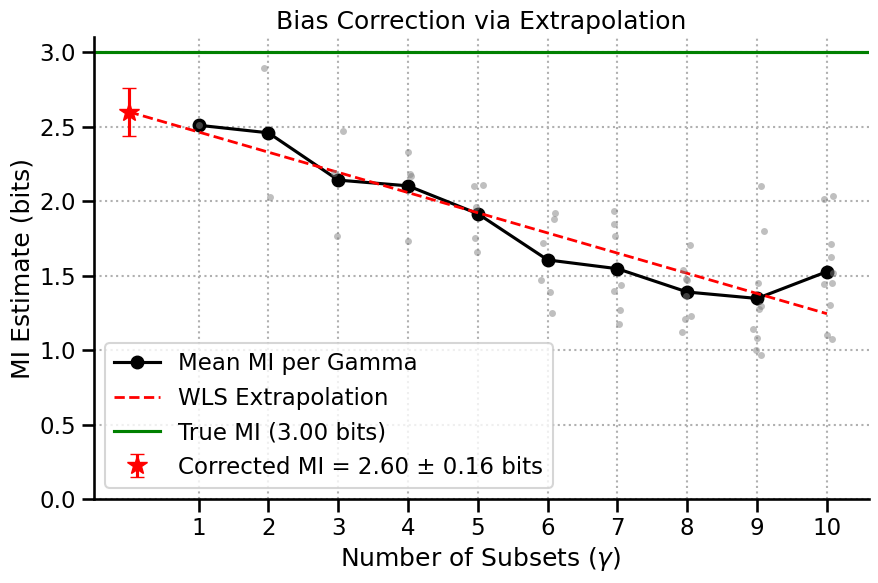

In [38]:
ax = rigorous_results.plot(show=False)
ax.axhline(y=3.0, color='green', linestyle='-', label=f'True MI ({3.0:.2f} bits)')
ax.legend()
ax.set_ylim(bottom=0)
plt.show()

## 4. Fine-Tuning the Rigorous Analysis

For advanced users, `nmi.run` provides parameters to control the bias correction procedure:

- `gamma_range (range)`: Sets the range of data splits to test. The default is `range(1, 11)`. A straight line on a larger range is a better sign.
- `delta_threshold (float)`: A measure of curvature used to find the 'linear region' of the MI vs 1/N plot for extrapolation. Lower values are stricter. The default is `0.1`.
- `min_gamma_points (int)`: The minimum number of points required for a reliable linear fit after pruning non-linear points. The default is `5`.

While the defaults are robust for most cases, these parameters offer more control for specialized analyses.

## 5. Conclusion

You now understand the most important feature of the `NeuralMI` library. Simple MI estimates are unreliable for scientific work, but `mode='rigorous'` provides a principled, automated workflow to correct for statistical biases and produce a final estimate with a confidence interval.

> **Recommendation:** For any final, scientific analysis where you actually care about the exact MI result, `mode='rigorous'` is the recommended mode.

In the next tutorial, we'll explore another advanced analysis for understanding the complexity of a single neural population.